**Proyecto Final**

* Asignatura: Despliegue de Modelos
* Profesor: Henry Ruiz

Presentado por:
* Joseph  David Gomez
* Daniela Restrepo

**Copyright 2021 The TensorFlow Hub Authors.
Licensed under the Apache License, Version 2.0 (the "License");**

In [ ]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Introducción

En este cuaderno, se implementa Model Maker para el dominio de audio, siendo parte de [Codelab para personalizar un modelo de audio e implementar en Android](https://codelabs.developers.google.com/codelabs/tflite-audio-classification-custom-model-android).

Para fines prácticos, se empleará un conjunto de datos de aves nocturnas presentes en Cali, Colombia y se exportará un modelo TFLite para desplegar el mismo en un teléfono móvil. 

* El Prototipo construido se puede consultar en [Edge Impulse](https://studio.edgeimpulse.com/public/156172/latest)

# Instalación de Dependencias
---

[La biblioteca TensorFlow Lite Model Maker](https://www.tensorflow.org/lite/models/modify/model_maker/audio_classification) simplifica el proceso de entrenamiento de un modelo de TensorFlow Lite con un conjunto de datos personalizado. Utiliza el aprendizaje por transferencia para reducir la cantidad de datos de entrenamiento requeridos y acortar el tiempo de entrenamiento.

Para instalar Modelo Maker se debe definir un paquete pip precompilado.



In [ ]:
!sudo apt -y install libportaudio2
!pip install tflite-model-maker

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 5 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 1s (129 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
d

# Librerías
---

Las siguientes librerias son requeridas para la reproducción, visualización y manipulación de audios.

In [2]:
import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import glob
import random

from IPython.display import Audio, Image
from IPython import display
from scipy.io import wavfile

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

TensorFlow Version: 2.8.4
Model Maker Version: 0.4.2


# Conjunto de Datos
---

El conjunto de datos es una colección de 5 tipos de cantos de buhos y aves nocturnas :

- Nyctibius griseus (Bien Parado)
- Bubo virginianus(Búho americano)
- Hydropsalis cayennensis (Chotacabras coliblanco)
- Nyctidromus-albicollis (Guardacamino cómun)
- Megascops choliba (Currucutu)
- Ruido-externo y Ruido Ambiental

El audio original proviene de [Xeno-canto](https://www.xeno-canto.org/), un sitio web dedicado a compartir sonidos de aves de todo el mundo.

In [3]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1k9C3hI8BeDHU_syoMal9I2D7dmQA6BZQ' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1k9C3hI8BeDHU_syoMal9I2D7dmQA6BZQ" -O Clasificacion-prueba.zip && rm -rf /tmp/cookies.txt

--2022-11-28 21:35:01--  https://docs.google.com/uc?export=download&confirm=t&id=1k9C3hI8BeDHU_syoMal9I2D7dmQA6BZQ
Resolving docs.google.com (docs.google.com)... 74.125.28.139, 74.125.28.100, 74.125.28.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.28.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-5k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7nehnua5ah1s27clgq7h5drkenmcd9a2/1669671300000/00457688035939158696/*/1k9C3hI8BeDHU_syoMal9I2D7dmQA6BZQ?e=download&uuid=adb6d181-a49c-4f7b-8c97-063079bf9888 [following]
--2022-11-28 21:35:01--  https://doc-0g-5k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7nehnua5ah1s27clgq7h5drkenmcd9a2/1669671300000/00457688035939158696/*/1k9C3hI8BeDHU_syoMal9I2D7dmQA6BZQ?e=download&uuid=adb6d181-a49c-4f7b-8c97-063079bf9888
Resolving doc-0g-5k-docs.googleusercontent.com (doc-0g-5k-docs.googleusercontent.com)... 173.194.213.132, 260

In [4]:
!unzip /content/Clasificacion-prueba.zip

Archive:  /content/Clasificacion-prueba.zip
   creating: Clasificacion-prueba/test/
   creating: Clasificacion-prueba/test/Bubo-virginianus/
  inflating: Clasificacion-prueba/test/Bubo-virginianus/Bubo-virginianus.Bubo-virginianus1.wav.3icr6svu.ingestion-74bd75dd6d-stwgs.s1.wav  
  inflating: Clasificacion-prueba/test/Bubo-virginianus/Bubo-virginianus.Bubo-virginianus1.wav.3icr6svu.ingestion-74bd75dd6d-stwgs.s2.wav  
  inflating: Clasificacion-prueba/test/Bubo-virginianus/Bubo-virginianus.Bubo-virginianus12.wav.3icr74jm.ingestion-74bd75dd6d-m84dq.s1.wav  
  inflating: Clasificacion-prueba/test/Bubo-virginianus/Bubo-virginianus.Bubo-virginianus12.wav.3icr74jm.ingestion-74bd75dd6d-m84dq.s2.wav  
  inflating: Clasificacion-prueba/test/Bubo-virginianus/Bubo-virginianus.Bubo-virginianus12.wav.3icr74jm.ingestion-74bd75dd6d-m84dq.s3.wav  
  inflating: Clasificacion-prueba/test/Bubo-virginianus/Bubo-virginianus.Bubo-virginianus15.wav.3icr71cp.ingestion-74bd75dd6d-67z58.s1.wav  
  inflating: Cl

## Exploración del Conjunto de Datos
---

Los audios ya están divididos en dos directorio, "train" y "test". Dentro de cada carpeta dividida, hay una carpeta para cada ave nocturna. Entre tanto, los audios son todos mono y con frecuencia de muestreo de 16 kHz.

La información sobre cada archivo, se encuentra deposita en la plataforma [Edge Impulse](https://studio.edgeimpulse.com/public/156172/latest).

In [5]:
# Se accede al directorio correspondiente y se une los archivos de la ruta de test.
data_dir = '/content/Clasificacion-prueba'
test_files = os.path.join('/content', data_dir, 'test/*/*.wav')

# Se codifica los nombres
bird_name = {
  'Nyctibius-griseus': 'Nyctibius griseus (Bien Parado)',
  'Bubo-virginianus':'Bubo virginianus(Búho americano)',
  'Hydropsalis-cayennensis': 'Hydropsalis cayennensis (Chotacabras coliblanco)',  
  'Nyctidromus-albicollis': 'Nyctidromus-albicollis (Guardacamino cómun)',
  'Megascops-choliba': 'Megascops choliba (Currucutu)',
  'Ruido-externo': "Ruido Ambiental",
}


In [6]:
# Se define función para escoger al azar uno de los archivos de test.
def get_random_audio_file():
  test_list = glob.glob(test_files)
  random_audio_path = random.choice(test_list)
  return random_audio_path

# Se define función para cargar los audios y mostrar información relevante. 
def show_bird_data(audio_path):
  sample_rate, audio_data = wavfile.read(audio_path, 'rb')
  bird_code = audio_path.split('/')[-2]
  print(f'Bird name: {bird_name[bird_code]}')
  print(f'Bird code: {bird_code}')

In [7]:
def load_wav(filename):
    #  Se carg archivo wav codificado
    file_contents = tf.io.read_file(filename)
    # Se decodifica wav (tensores por canales)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Se remueve el trailing axis
    wav = tf.squeeze(wav, axis=-1)
    return wav


## Reproduciendo muestra de audio
---
A fin de comprender los datos dispuestos, en esta sección se señala un audio aleatorio de la división de test.

Bird name: Bubo virginianus(Búho americano)
Bird code: Bubo-virginianus


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: WavFileWarning: Reached EOF prematurely; finished at 384044 bytes, expected 384052 bytes from header.
  if __name__ == '__main__':


(192000,)


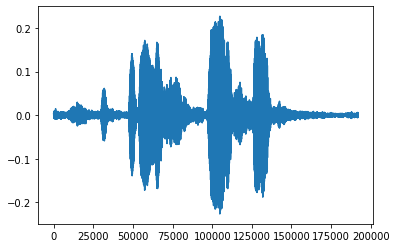

In [8]:
random_audio = get_random_audio_file()

show_bird_data(random_audio)

display.display(display.Audio(random_audio, rate=44100))

wave = load_wav(random_audio)
print(wave.shape)
plt.plot(wave)
plt.show()

# Construcción del modelo
---
Se emple Model Maker para Audio, para ello se especifica el modelo. Este es el modelo base que se emplea para extraer información de las nuevas clases. 

[YAMNet](https://tfhub.dev/google/yamnet/1) es un clasificador de eventos de audio entrenado en el conjunto de datos AudioSet para predecir eventos de audio a partir de la ontología AudioSet.

Se espera que su entrada sea a 16kHz y con 1 canal.

In [9]:
spec = audio_classifier.YamNetSpec(
    keep_yamnet_and_custom_heads=True,
    # Se define cuánto dura cada muestra de entrenamiento
    frame_step=4* audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH)

# Carga del Conjunto de Datos en el Modelo
---
Model Maker tiene la API para cargar los datos de una carpeta y tenerlos en el formato esperado para la especificación del modelo.

La división de tren y prueba se basa en las carpetas. El conjunto de datos de validación se creará como el 20 % de la división del tren.




In [10]:
train_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'train'), cache=True)
train_data, validation_data = train_data.split(0.8)
test_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'test'), cache=True)

# Entrenamiento
---

Se utiliza todas las configuraciones predeterminadas y se entrena durante 100 épocas.

Sl clasificador de audio tiene el método [`create`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/audio_classifier/create) que crea un modelo y comienza a entrenarlo.


In [14]:
print('Training the model')
model = audio_classifier.create(
    train_data,
    spec,
    validation_data,
    batch_size=64,
    epochs=100)

Training the model
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 classification_head (Dense)  (None, 6)                6150      
                                                                 
Total params: 6,150
Trainable params: 6,150
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 57s 4s/step - loss: 2.4606 - acc: 0.1731 - val_loss: 1.6237 - val_acc: 0.2642
Epoch 2/100
4/4 [==============================] - 0s 102ms/step - loss: 1.7993 - acc: 0.2548 - val_loss: 1.6433 - val_acc: 0.1887
Epoch 3/100
4/4 [==============================] - 0s 116ms/step - loss: 1.6383 - acc: 0.2981 - val_loss: 1.6071 - val_acc: 0.2453
Epoch 4/100
4/4 [==============================] - 0s 115ms/step - loss: 1.4522 - acc: 0.3558 - val_loss: 1.3942 - val_acc: 0.3962
Epoch 5/100
4/4 [======================

In [12]:
print('Evaluating the model')
model.evaluate(test_data)

Evaluating the model
3/3 [==============================] - 14s 3s/step - loss: 0.8657 - acc: 0.7361


[0.8656707406044006, 0.7361111044883728]

# Desempeño del Modelo
---

La matriz de confusión le brinda un conocimiento detallado de cómo se está desempeñando el clasificador en los datos de prueba.

Model Maker ya crea la matriz de confusión.

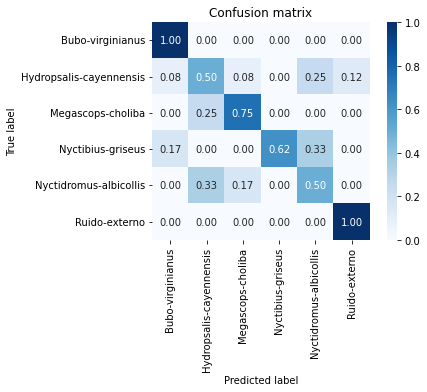

In [15]:
def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  axis_labels = test_labels
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

confusion_matrix = model.confusion_matrix(test_data)
show_confusion_matrix(confusion_matrix.numpy(), test_data.index_to_label)

# Verificación de Inferencias
---
Se prueba el modelo en un audio de muestra del conjunto de datos de prueba solo para ver los resultados.


In [16]:
serving_model = model.create_serving_model()

print(f'Model\'s input shape and type: {serving_model.inputs}')
print(f'Model\'s output shape and type: {serving_model.outputs}')

Model's input shape and type: [<KerasTensor: shape=(None, 15600) dtype=float32 (created by layer 'audio')>]
Model's output shape and type: [<KerasTensor: shape=(None, 521) dtype=float32 (created by layer 'keras_layer')>, <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'sequential_1')>]


## Exportar el modelo

El último paso es exportar el modelo para usarlo en dispositivos integrados o en el navegador.

In [17]:
models_path = './birds_models'
print(f'Exporing the TFLite model to {models_path}')

model.export(models_path, tflite_filename='my_birds_model.tflite')

Exporing the TFLite model to ./birds_models
